In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from mpl_toolkits import mplot3d
from useful import get_data, SVM_linear, SVM_nonlinear

w =  [[3.07293116 2.08681869]]
b =  [-101.9883115]


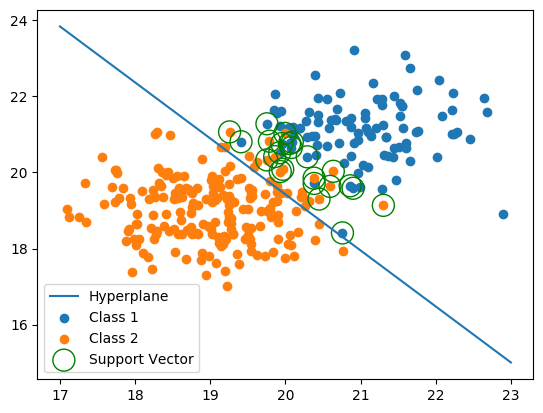

Samples Tested:  300
Total Errors:  24
Accuracy:  0.92


In [27]:
# Test SVM on Synthetic Data

# Generate data
n1, n2 = 100, 200
t = np.array([*[1]*n1, *[-1]*n2])
x_test = np.random.normal(0, 0.8, (n1+n2, 2)) + t.reshape((n1+n2, 1)) + 20

# Learn SVM
w, b, svi = SVM_linear(x_test, t, C=10)

print("w = ", w)
print("b = ", b)

# Plot results
x_axis_values = np.linspace(17, 23, 50)
plt.scatter(x_test[:n1, 0], x_test[:n1, 1], label="Class 1")
plt.scatter(x_test[n1:n1+n2, 0], x_test[n1:n1+n2, 1], label="Class 2")
plt.scatter(x_test[svi, 0], x_test[svi, 1], label="Support Vector", s=250, facecolors='none', edgecolors='green')
plt.plot(x_axis_values, - (x_axis_values*w[0, 0] + b) / w[0, 1], label="Hyperplane")
plt.legend()
plt.show()
test_SVM(x_test, t, w, b)

In [3]:
# Collect gesture data
up_data, up_t = get_data("up_data.txt")
circle_data, circle_t = get_data("circle_data.txt")
data = np.array([*up_data, *circle_data]).T
time_array = np.array([*up_t, *circle_t]).T

(d, N) = time_array.shape
N_h = N//2

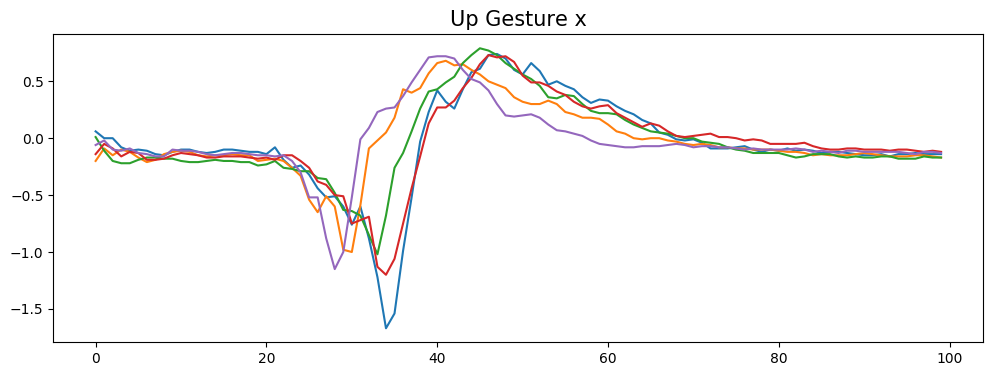

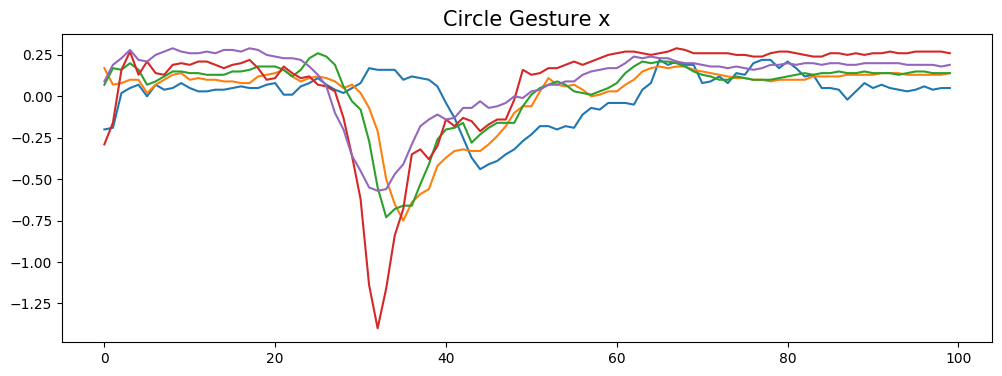

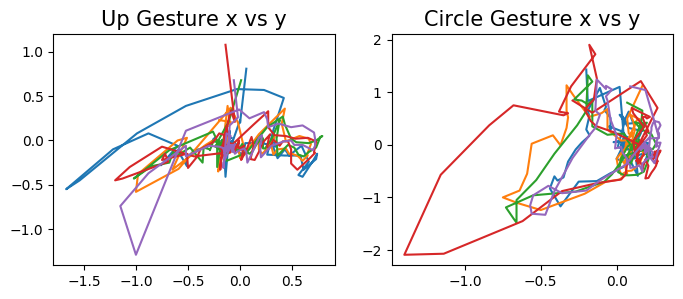

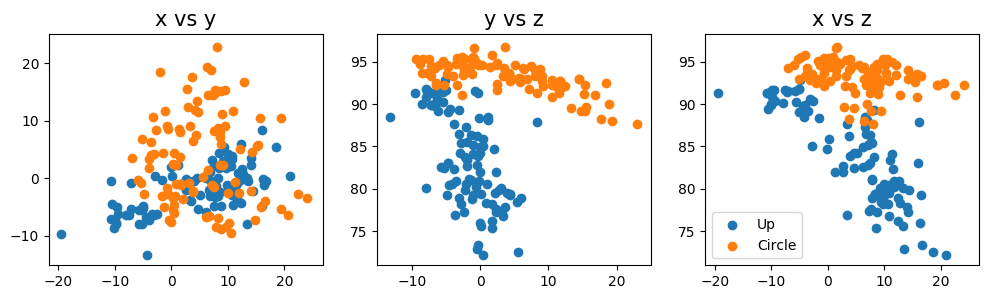

In [4]:
# Visualise data
plt.figure(figsize=(12, 4))
plt.title("Up Gesture x", fontsize=15)
plt.plot(data[:d, :5])
plt.show()

plt.figure(figsize=(12, 4))
plt.title("Circle Gesture x", fontsize=15)
plt.plot(data[:d, N_h:N_h+5])
plt.show()

fig, axs = plt.subplots(1, 2,  figsize=(8,3))
axs[0].set_title("Up Gesture x vs y", fontsize=15)
axs[0].plot(data[:d, :5], data[d:2*d, :5])
axs[1].set_title("Circle Gesture x vs y", fontsize=15)
axs[1].plot(data[:d, N_h:N_h+5], data[d:2*d, N_h:N_h+5])
plt.show()

fig, axs = plt.subplots(1, 3,  figsize=(12,3))
axs[0].set_title("x vs y", fontsize=15)
axs[0].scatter(data[:d, :N_h].sum(axis=0), data[d:2*d, :N_h].sum(axis=0), label="Up")
axs[0].scatter(data[:d, N_h:N].sum(axis=0), data[d:2*d, N_h:N].sum(axis=0), label="Circle")
axs[1].set_title("y vs z", fontsize=15)
axs[1].scatter(data[d:2*d, :N_h].sum(axis=0), data[2*d:3*d, :N_h].sum(axis=0), label="Up")
axs[1].scatter(data[d:2*d, N_h:N].sum(axis=0), data[2*d:3*d, N_h:N].sum(axis=0), label="Circle")
axs[2].set_title("x vs z", fontsize=15)
axs[2].scatter(data[:d, :N_h].sum(axis=0), data[2*d:3*d, :N_h].sum(axis=0), label="Up")
axs[2].scatter(data[:d, N_h:N].sum(axis=0), data[2*d:3*d, N_h:N].sum(axis=0), label="Circle")
plt.legend()
plt.show()

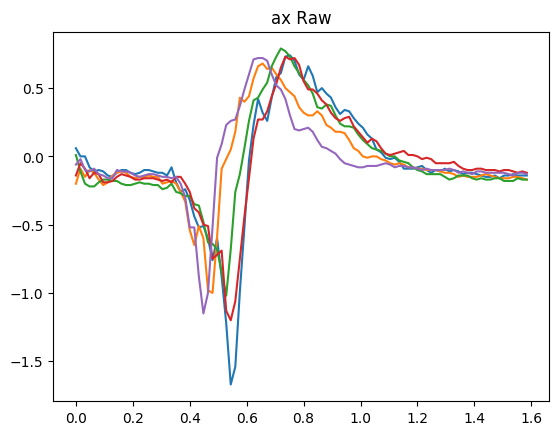

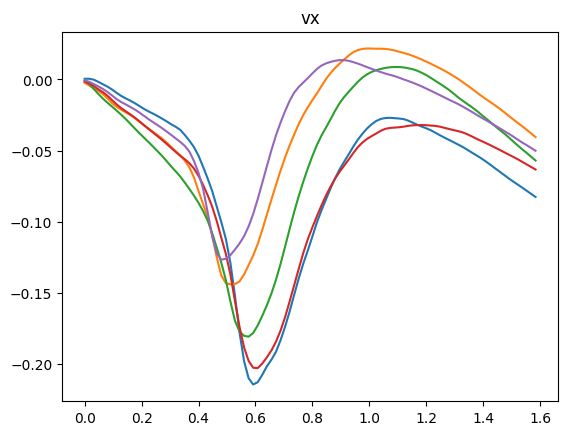

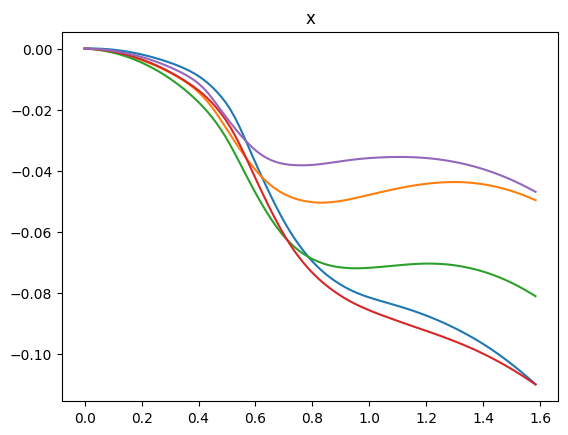

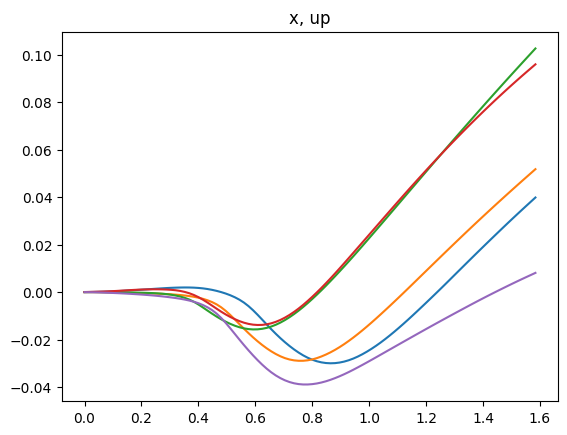

(200, 309)
(200,)


In [5]:
# Condense and format feature data
def get_features(data, time_array):
    """Given raw data, create feature vector."""
    N_t, N = data.shape[0]//3, data.shape[1]

    # Raw acceleration values
    ax, ay, az = data[:N_t, :], data[N_t:N_t*2, :], data[N_t*2:N_t*3, :]

    # # Differentiate
    # dax = (ax[1:] - ax[:99]) / (time_array[1:] - time_array[:99])
    # day = (ay[1:] - ay[:99]) / (time_array[1:] - time_array[:99])
    # daz = (az[1:] - az[:99]) / (time_array[1:] - time_array[:99])

    # Integrate
    vx = np.zeros((N_t, N))
    s = 0
    for i in range(N_t-1):
        s += (time_array[i+1] - time_array[i]) * (ax[i+1] + ax[i])/2
        vx[i] = s
    vx[-1] = 2*vx[-2] - vx[-3]


    # And again...
    x = np.zeros((N_t, N))
    s = 0
    for i in range(N_t-1):
        s += (time_array[i+1] - time_array[i]) * (vx[i+1] + vx[i])/2
        x[i] = s
    x[-1] = 2*x[-2] - x[-3]

    plt.title("ax Raw")
    plt.plot(time_array[:, :5], ax[:, :5])
    plt.show()

    plt.title("vx")
    plt.plot(time_array[:, :5], vx[:, :5])
    plt.show()

    plt.title("x")
    plt.plot(time_array[:, :5], x[:, :5])
    plt.show()

    plt.title("x, up")
    plt.plot(time_array[:, :5], x[:, 51:56])
    plt.show()

    def get_dist(x, r, bins=100):
        dist = np.zeros((bins, N))
        for i in range(N):
            dist[:, i] = np.histogram(x[:, i], bins=bins, range=r)[0]
        return dist

    # ax Distributions
    ax_dist_vals = np.linspace(-1.7, 0.8, 20)
    ax_dist = get_dist(ax, r=(-1.7, 0.8))

    # vx Distributions
    vx_dist_vals = np.linspace(-0.25, 0.05, 20)
    vx_dist = get_dist(vx, r=(-0.25, 0.05))

    # x Distributions
    x_dist_vals = np.linspace(-0.15, 0.1, 20)
    x_dist = get_dist(x, r=(-0.15, 0.1))
    
    X = np.array([
        ax.sum(axis=0),
        ay.sum(axis=0),
        az.sum(axis=0),
        ax.max(axis=0),
        ay.max(axis=0),
        az.max(axis=0),
        ax.min(axis=0),
        ay.min(axis=0),
        az.min(axis=0),
        *ax_dist,
        *x_dist,
        *vx_dist,
    ]).T
    return X
X = get_features(data, time_array)
t = np.array([*[1]*N_h, *[-1]*N_h])
print(X.shape)
print(t.shape)

In [6]:
# Learn SVM
w, b, svi = SVM_linear(X, t, C=10)
print("w = ", w)
print("b = ", b)

w =  [[ 3.53068742e-02 -5.81287630e-03 -1.24487878e-01  7.57306071e-03
  -1.58103676e-02  2.95299937e-02 -1.28569862e-02  9.66952485e-03
  -2.65925949e-02 -1.62928564e-08 -1.71733125e-08  4.87743039e-04
  -2.34780793e-08  1.57260812e-03  2.57253047e-03  9.99925876e-04
   1.31087740e-04  4.10128310e-04 -2.66432845e-08 -8.25494914e-08
   1.31072039e-04  1.00181627e-03  4.82741874e-03 -2.09883034e-08
  -2.62260031e-04  9.88478852e-05  1.26999121e-04  2.67247019e-04
  -2.59985201e-08  3.67949103e-06  1.30855978e-03  9.97990690e-04
   5.36643046e-03  9.88843651e-05  1.33258786e-02  1.94282270e-03
  -6.42029058e-04  1.26362336e-03  4.82348973e-04 -7.73264223e-04
   1.12084627e-03 -1.28428126e-03  1.16714452e-03  1.17492268e-04
   8.01961058e-04  1.12275125e-04  6.17692420e-03  7.51946117e-03
  -3.25711769e-03  2.71372372e-03 -6.92323814e-03 -8.63636273e-04
   3.17340503e-03 -1.02225270e-02 -7.02152927e-03 -3.26513851e-03
  -1.58834268e-02 -5.46560012e-03 -6.67788967e-03 -4.19799107e-03
  -1.

86.7


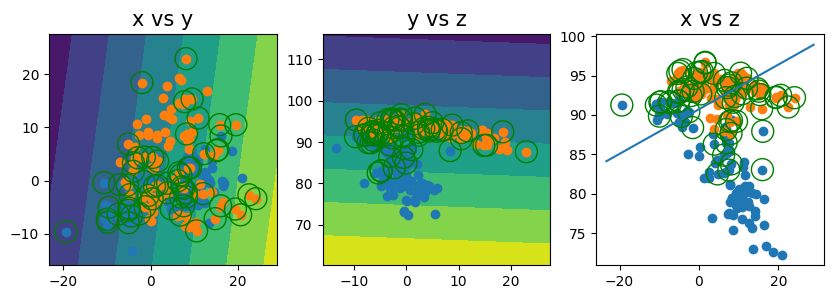

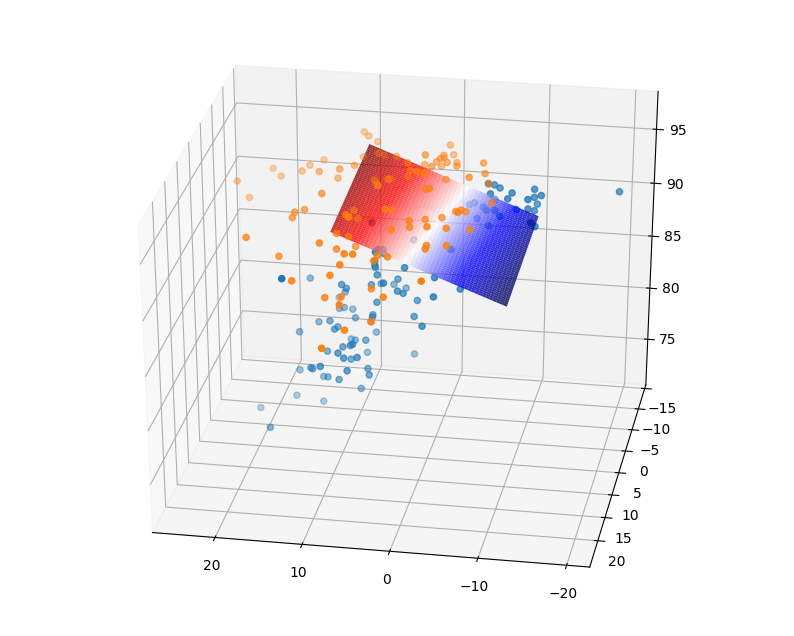

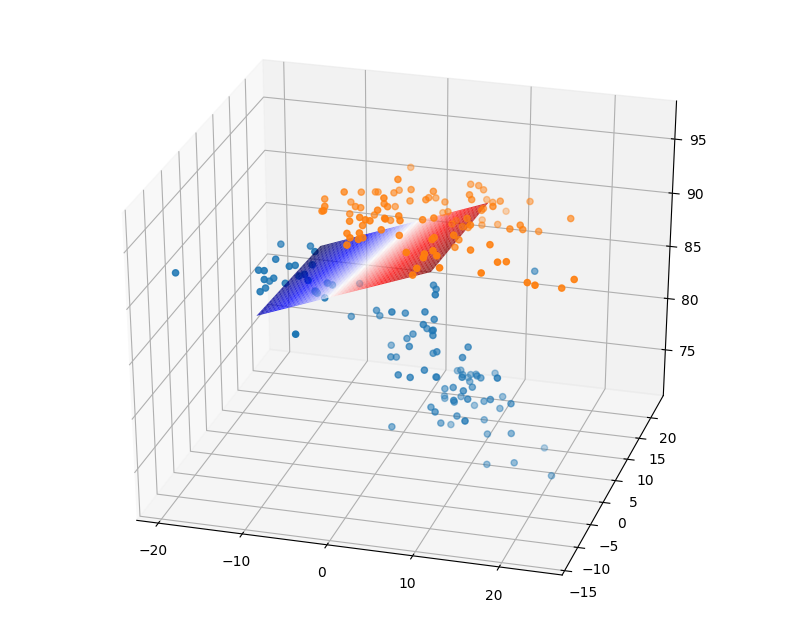

KeyboardInterrupt: 

In [13]:
%matplotlib inline
# Plot separating hyperplane
from time import sleep

scale = 1.2
line_x = np.linspace(X[:, 0].min()*scale, X[:, 0].max()*scale, N)
line_y = np.linspace(X[:, 1].min()*scale, X[:, 1].max()*scale, N)
line_z = np.linspace(X[:, 2].min()/scale, X[:, 2].max()*scale, N)
print(X[:, 2].min()*scale)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].set_title("x vs y", fontsize=15)
X_grid, Y_grid = np.meshgrid(line_x, line_y)
axs[0].contourf(X_grid, Y_grid, X_grid * w[0, 0] + Y_grid * w[0, 1] + b)
axs[0].scatter(X[:N_h, 0], X[:N_h, 1], label="Up")
axs[0].scatter(X[N_h:N, 0], X[N_h:N, 1], label="Circle")
axs[0].scatter(X[svi, 0], X[svi, 1], label="Support Vector", s=250, facecolors='none', edgecolors='green')
# axs[0].plot(line_x, - (line_x * w[0, 0] + b) / w[0, 1])

# axs[0].set_ylim(-20, 10)

axs[1].set_title("y vs z", fontsize=15)
Y_grid, Z_grid = np.meshgrid(line_y, line_z)
axs[1].contourf(Y_grid, Z_grid, Y_grid * w[0, 1] + Z_grid * w[0, 2] + b)
axs[1].scatter(X[:N_h, 1], X[:N_h, 2], label="Up")
axs[1].scatter(X[N_h:N, 1], X[N_h:N, 2], label="Circle")
# axs[1].plot(line_y, - (line_y * w[0, 1] + b) / w[0, 2])
axs[1].scatter(X[svi, 1], X[svi, 2], label="Support Vector", s=250, facecolors='none', edgecolors='green')
# axs[1].set_ylim(-20, 10)

axs[2].set_title("x vs z", fontsize=15)
axs[2].scatter(X[:N_h, 0], X[:N_h, 2], label="Up")
axs[2].scatter(X[N_h:N, 0], X[N_h:N, 2], label="Circle")
axs[2].plot(line_x, - (line_x * w[0, 0] + b) / w[0, 2])
axs[2].scatter(X[svi, 0], X[svi, 2], label="Support Vector", s=250, facecolors='none', edgecolors='green')
# axs[2].set_ylim(80, 100)
plt.show()


# 3D Plot 
x_surface = np.outer(np.linspace(-10, 10, 50), np.ones(50)) 
y_surface = x_surface.copy().T
z_surface = - (x_surface * w[0, 0] + y_surface * w[0, 1] + b) / w[0, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(X[:N_h, 0], X[:N_h, 1], X[:N_h, 2])
ax.scatter(X[N_h:N, 0], X[N_h:N, 1], X[N_h:N, 2])
ax.plot_surface(x_surface, y_surface, z_surface, cmap='seismic', alpha=0.8)
ax.view_init(30, 100)
plt.show()

# This is a useful rotation animation but will destroy the computer
hfig = display(fig, display_id=True)
for angle in range(50, 360):
    ax.view_init(30, 2*angle)
    fig.canvas.draw()
    hfig.update(fig)
    sleep(0.001)

In [14]:
def test_SVM(X, t, w, b):
    (N, d) = X.shape
    y = np.dot(w, X.T) + b
    errors = [1 if y[0, i]*t[i] < 0 else 0 for i in range(N)]
    print("Samples Tested: ", N)
    print("Total Errors: ", sum(errors))
    print("Accuracy: ", (N - sum(errors))/N)

In [15]:
up_test_data, up_t = get_data("up_test_data.txt")
circle_test_data, circle_t = get_data("circle_test_data.txt")
test_data = np.array([*up_test_data, *circle_test_data]).T
test_time_array = np.array([*up_t, *circle_t]).T
test_time_array = (test_time_array - test_time_array[0, :]) / 1000

(test_d, test_N) = test_time_array.shape
test_N_h = test_N//2

test_t = np.array([*[1]*test_N_h, *[-1]*test_N_h])

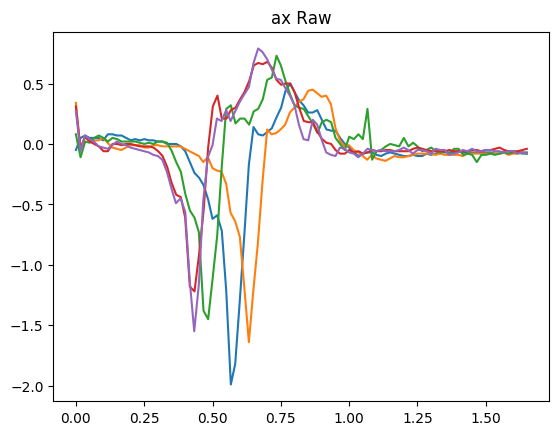

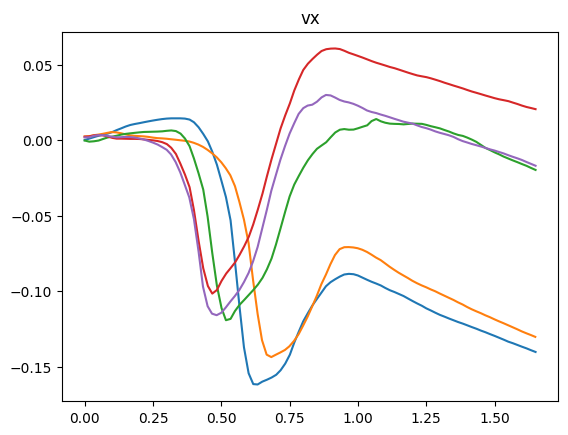

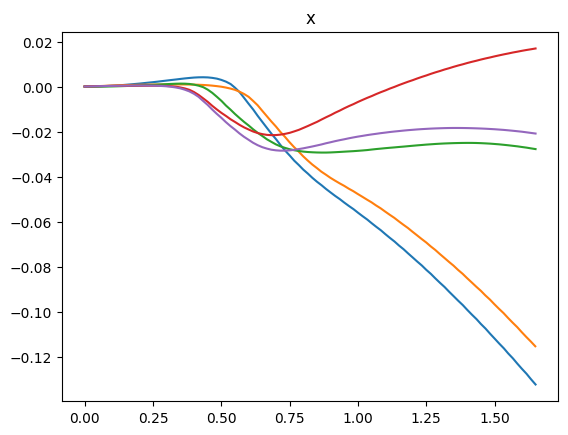

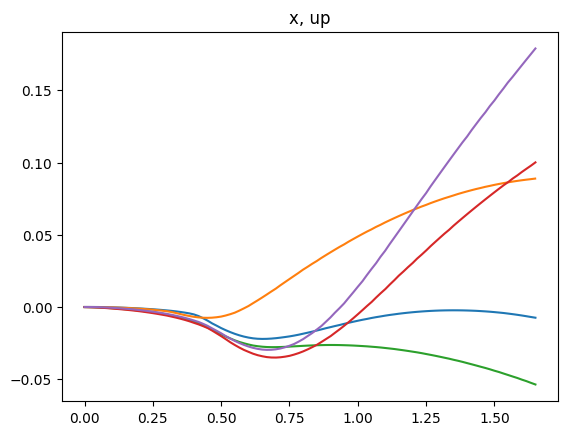

Samples Tested:  150
Total Errors:  0
Accuracy:  1.0


In [16]:
X_test = get_features(test_data, test_time_array)
test_SVM(X_test, test_t, w, b)

In [19]:
K = lambda Xn, Xm, gam=0.8: pyo.exp(-gam * np.linalg.norm(Xn - Xm)**2)
K_pred = lambda Xn, Xm, gam=0.8: np.exp(-gam * np.linalg.norm(Xn - Xm, axis=1)**2)
a, b, svi = SVM_nonlinear(X, t, K, C=10)

In [20]:
def test_nonlinear_SVM(X_test, test_t, X, t, a, b):
    (N_test, d) = X_test.shape
    N = X.shape[0]
    y = np.zeros(N_test)
    for n in range(N):
        y += a[n] * t[n] * K_pred(X[n], X_test)
    errors = [1 if y[i]*test_t[i] < 0 else 0 for i in range(N_test)]
    print("Samples Tested: ", N_test)
    print("Total Errors: ", sum(errors))
    print("Accuracy: ", (N - sum(errors))/N)

test_nonlinear_SVM(X_test, test_t, X, t, a, b)

Samples Tested:  150
Total Errors:  0
Accuracy:  1.0


In [21]:
# Test and visualise the nonlinear SVM
n = 50
n_h = n // 2
t = np.array([*[1]*n_h, *[-1]*n_h])
x_test = np.random.normal(0, 0.8, (n, 2)) + t.reshape((n, 1)) + 20
a, b, svi = SVM_nonlinear(x_test, t, K, C=10)
print(x_test.shape)

n_contour = 100
x_line = np.linspace(16, 24, n_contour)
y_line = np.linspace(16, 24, n_contour)

X_grid, Y_grid = np.meshgrid(x_line, y_line)
z = np.zeros((n_contour, n_contour))
for n in range(n_contour):
    for m in range(n_contour):
        for k in range(50):
            z[n, m] += a[k] * t[k] * K(np.array([X_grid[n, m], Y_grid[n, m]]), x_test[k])

(50, 2)


Samples Tested:  50
Total Errors:  0
Accuracy:  1.0


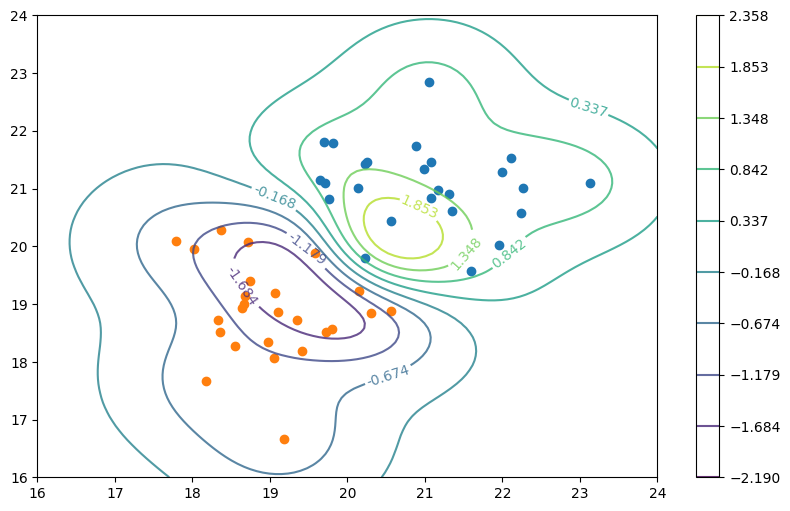

In [22]:
plt.figure(figsize=(10, 6))
CS = plt.contour(X_grid, Y_grid, z, levels=np.linspace(z.min(), z.max(), 10), alpha=0.8)
plt.clabel(CS, inline=1, fontsize=10)
plt.colorbar(CS)
plt.scatter(x_test[:n_h, 0], x_test[:n_h, 1])
plt.scatter(x_test[n_h:n, 0], x_test[n_h:n, 1])
test_nonlinear_SVM(x_test, t, x_test, t, a, b)
plt.show()